# What can we do with DFT? - Exercises
In this notebook, you find some exercises related with what can be done using DFT

For the first 3 exercises, we recommend using LCAO mode for speed, so you can use the following settings for your calculator object in all of the exercises.

```python
calc = GPAW(h=0.24,
            mode='lcao',
            basis='sz(dzp)',
            xc='PBE')
```
The Single-$\zeta$ (sz) basis set is not a very good basis set, and is generally not used for real calculations. However, for our purposes, and to speed up the calculations, this will be sufficient. For a real simulation, one would generally use a double-$\zeta$ polarized (dzp) basis set at least. The `sz(dzp)` basis means, that we use the `sz` sub-basis from the larger `dzp` basis set.

For relaxations we recommend the `BFGS` method.

## Exercise 1
Calculate the relaxed geometry of ammonia, NH$_3$, and its atomization energy with respect to H$_2$ and N$_2$, and with respect to isolated H and N.

See the following GPAW tutorial for inspiration: https://wiki.fysik.dtu.dk/gpaw/tutorials/H2/atomization.html

For building molecules, refer to the ASE wiki: https://wiki.fysik.dtu.dk/ase/ase/build/build.html#molecules

Questions: 
* Why do we use N2 and H2 as references for the atomization energy?
* What shall we include in the calculator object if we want to use N and H as reference systems?
* How much does the atomization energy changes if we use N and H as reference systems instead of N2 and H2?
* Extra question

In [ ]:
%%writefile ex1.py
# teacher
import pickle
from ase.build import molecule
from ase.visualize import view
from ase.optimize import BFGS
from ase.parallel import parprint, paropen
from gpaw import GPAW

energies = {}

for name in ['NH3', 'H2', 'N2', 'H', 'N']:
    system = molecule(name)
    system.center(vacuum=10)

    calc = GPAW(h=0.24,
                mode='lcao',
                basis='sz(dzp)',
                xc='PBE',
                txt='relax-'+name+'.txt'
                )
    # When do we need to set Hund's rule?
    if name == 'H' or name == 'N': 
        calc.set(hund=True)

    system.set_calculator(calc)
    relax = BFGS(system, trajectory='relax-'+name+'.traj', logfile='relax-'+name+'.log')
    relax.run(fmax=0.05)
    
    energy = system.get_potential_energy()
    energies[name] = energy
    parprint(name, energy)

# Atomization energies of ammonia
e_atomization1 = energies['NH3'] - 3/2. * energies['H2'] - 1/2. * energies['N2']
e_atomization2 = energies['NH3'] - 3 * energies['H'] - energies['N']

parprint(e_atomization1, e_atomization2)
# Store energies dictionary for later
with paropen('energies_ex1.pckl', 'wb') as f:
    pickle.dump(energies, f)

In [ ]:
!qsub.py -t 1 -p 8 ex1.py

In [ ]:
!qstat -u $USER

In [1]:
# teacher
import pickle
with open('energies_ex1.pckl', 'rb') as f:
    energies = pickle.load(f)
e_atomization1 = energies['NH3'] - 3/2. * energies['H2'] - 1/2. * energies['N2']
e_atomization2 = energies['NH3'] - 3 * energies['H'] - energies['N']
print('Atomization 1: {:.3f} eV\nAtomization 2: {:.3f} eV'.format(e_atomization1, e_atomization2))

Atomization 1: -1.672 eV
Atomization 2: -9.714 eV


## Exercise 2
Calculate the vibrational modes of ammonia.

See https://wiki.fysik.dtu.dk/ase/ase/vibrations/vibrations.html

Questions:
* Is the highest frequency mode of ammonia larger than the one of water?
* What is the shape of the highest vibrational mode of ammonia?

In [ ]:
%%writefile ex2.py
# teacher
from ase import Atoms
from ase.io import read
from ase.vibrations import Vibrations
from ase.parallel import paropen
from gpaw import GPAW

atoms = read('relax-NH3.traj')
calc = GPAW(h=0.24,
            mode='lcao',
            basis='sz(dzp)',
            xc='PBE',
            txt='vibrational-NH3.txt'
            )
atoms.set_calculator(calc)

# Create vibration calculator
vib = Vibrations(atoms)
vib.run()
with paropen('ex2_log.txt', 'w') as log:
    vib.summary(method='frederiksen', log=log)

# Make trajectory files to visualize normal modes:
for mode in range(12):
    vib.write_mode(mode)

In [ ]:
#%%writefile ex2.py
# student
from ase.io import read

atoms = read(?)  # Load the relaxed ammonia from the previous exercise
calc = ?
atoms.set_calculator(calc)

# Create vibration calculator
vib = ?

# Make trajectory files to visualize normal modes:
for mode in range(3*len(atoms)):  # 3N vibrational modes, where N is the number of atoms
    vib.write_mode(mode)

In [ ]:
# Visualize the modes we just made
# Change the number to a mode between 0-11
!ase gui vib.0.traj

In [ ]:
!qsub.py -t 1 -p 8 ex2.py

In [ ]:
!qstat -u $USER

In [2]:
!cat ex2_log.txt

---------------------
  #    meV     cm^-1
---------------------
  0   43.1i    347.7i
  1   36.6i    295.5i
  2   18.0i    145.2i
  3    1.2i      9.7i
  4    1.0       7.7 
  5    5.2      42.1 
  6   75.8     611.5 
  7  180.3    1454.4 
  8  184.8    1490.4 
  9  348.6    2811.5 
 10  388.1    3130.4 
 11  389.5    3141.6 
---------------------
Zero-point energy: 0.787 eV


## Exercise 3
Set up a 2x2x3 Pt(111) surface with the two bottom layers constraint and calculate the adsorption energy of H on its hollow, bridge and top sites. You can reuse the energies from exercise 1 for the energy of an H$_2$ molecule.

Use a (2x2x1) k-point sampling for your surface.

See
https://wiki.fysik.dtu.dk/ase/ase/build/surface.html

https://wiki.fysik.dtu.dk/ase/ase/build/surface.html#ase.build.add_adsorbate

**Important:** Remember to always visualize your structures!

Questions:
* What is the most stable adsorption site on Pt111
* When do we need to include k-points in a calculator?
* Do you think that a (2x2x1) k-point mesh is a sufficient number for a good simulation? Why?

In [ ]:
%%writefile ex3.py
#teacher
import pickle
from ase.build import fcc111, add_adsorbate
from ase.constraints import FixAtoms
from ase.parallel import paropen, parprint
from ase.optimize import BFGS
from gpaw import GPAW, FermiDirac

slab = fcc111('Pt', size=(2, 2, 3), vacuum=10.0)
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag > 1])
slab.set_constraint(c)

# Remember to visualize your structure
if 0: # for viewing only. Set to 1 to view, and 0 to ignore
    from ase.visualize import view
    add_adsorbate(slab, 'H', 1.5, 'bridge')
    view(slab)
    assert False # Hack to break the execution by raising an error intentionally.

energies_slab = {}


# First we relax the slab
settings = {'h': 0.24,
            'mode': 'lcao',
            'basis': 'sz(dzp)',
            'occupations': FermiDirac(0.05),
            'kpts': (2, 2, 1),
            'xc': 'PBE'}

calc = GPAW(txt='relax-Pt111_clean.txt', **settings)

slab.set_calculator(calc)
parprint('Relaxing clean')

relax = BFGS(slab, trajectory='relax-Pt111_clean.traj', logfile='relax-Pt111_clean.log')
relax.run(fmax=0.05)
calc.write('Pt111_clean.gpw')  # We are going to need this gpw file later
energies_slab['clean'] = slab.get_potential_energy()

# Run through the configurations with a H adsorbate
for position in ['ontop', 'bridge', 'fcc', 'hcp']:
    parprint('Relaxing {}'.format(position))
    atoms = slab.copy()  # Make a new clean copy
    
    add_adsorbate(atoms, 'H', 1.5, position)
    name = 'H-'+position
    
    calc = GPAW(txt='relax-Pt111_'+name+'.txt', **settings)
    
    atoms.set_calculator(calc)
    relax = BFGS(atoms, trajectory='relax-Pt111_'+name+'.traj', logfile='relax-Pt111_'+name+'.log')
    relax.run(fmax=0.05)
    calc.write('Pt111_'+name+'.gpw')
    energies_slab[position] = atoms.get_potential_energy()


# Get energies for H2 we calculated earlier
with paropen('energies_ex1.pckl', 'rb') as f:
    energies = pickle.load(f)

e_ontop = energies_slab['ontop'] - energies_slab['clean'] - 1/2. * energies['H2']
e_bridge = energies_slab['bridge'] - energies_slab['clean'] - 1/2. * energies['H2']
e_fcc = energies_slab['fcc'] - energies_slab['clean'] - 1/2. * energies['H2']
e_hcp = energies_slab['hcp'] - energies_slab['clean'] - 1/2. * energies['H2']

with paropen('ex3_results.txt', 'w') as f:
    print('Ontop: {:.3f} eV\nBridge: {:.3f} eV\nfcc: {:.3f} eV\nhcp: {:.3f} eV'.format(e_ontop, e_bridge, e_fcc, e_hcp), file=f)

In [ ]:
#%%writefile ex3.py
# student
from ase.constraints import FixAtoms
from ase.build import fcc111, add_adsorbate

slab = fcc111(?)  # Construct your pt111 (2x2x3) surface
# Constrain everything but the top layer
c = FixAtoms(indices=[atom.index for atom in slab if atom.tag > 1])
slab.set_constraint(c)

# Relax the clean surface first

# Adding adsorbates
position = 'fcc'  # Specify site
add_adsorbate(slab, 'H', 1.5, position)

In [ ]:
# This calculation might take a while, so we use more processors
!qsub.py -t 2 -p 32 ex3.py

In [ ]:
!qstat -u $USER

In [3]:
!cat ex3_results.txt

Ontop: -0.690 eV
Bridge: -0.564 eV
fcc: -0.537 eV
hcp: -0.573 eV


## Exercise 4

For this exercise, we need to switch from LCAO mode to Plane-Wave (PW) mode, as we only have the stress-tensor in PW mode.

Optimize NaCl using the stress tensor (check convergence of k-points and PW mode cutoff before running the optimization). Remember to save the gpw file of the relaxed configuration, because you will need it later. Saving the gpw file is done from the calculator, see https://wiki.fysik.dtu.dk/gpaw/tutorials/plotting/plot_wave_functions.html#creating-a-wave-function-file

See https://wiki.fysik.dtu.dk/gpaw/exercises/stress/stress.html on doing Plane-Wave calculations. Also see https://wiki.fysik.dtu.dk/ase/ase/constraints.html#ase.constraints.UnitCellFilter on relaxing using the stress tensor.

Use a (NxNxN) k-point sampling for the NaCl cell.

Questions:
* What is the relaxed lattice parameter for NaCl?

In [ ]:
%%writefile ex4a.py
#teacher
import pickle
from ase.spacegroup import crystal
from ase.parallel import paropen
from gpaw import GPAW, PW

a = 5.64
nacl = crystal(['Na', 'Cl'], [(0, 0, 0), (0.5, 0.5, 0.5)], spacegroup=225, cellpar=[a, a, a, 90, 90, 90])

if 0:
    from ase.visualize import view
    view(nacl)
    assert False

energies = {}
kpts = [2, 3, 4, 5]
ecuts = range(200, 801, 100)
for k in kpts:
    energies[k] = {}
    for ecut in ecuts:
        calc = GPAW(mode=PW(ecut),
                       xc='PBE',
                       kpts=(k, k, k),
                       txt='NaCl-'+str(k)+'-'+str(ecut)+'.txt')
        nacl.set_calculator(calc)
        en = nacl.get_potential_energy()
        energies[k][ecut] = en
        
with paropen('energies_ex4a.pckl', 'wb') as f:
    pickle.dump(energies, f)

In [ ]:
!qsub.py -p 8 -t 1 ex4a.py

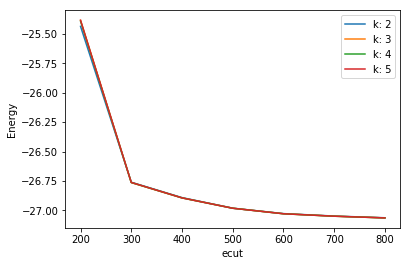

In [4]:
# teacher
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
with open('energies_ex4a.pckl', 'rb') as f:
    energies = pickle.load(f)

kpts = [2, 3, 4, 5]
ecuts = range(200, 801, 100)

for k in kpts:
    y = []
    for ecut in ecuts:
        y.append(energies[k][ecut])
    plt.plot(ecuts, y, label='k: '+str(k))
plt.xlabel('ecut')
plt.ylabel('Energy')
plt.legend(loc='best')
plt.show()

In [ ]:
#%%writefile ex4a.py
# student
from ase.spacegroup import crystal

# Set up a NaCl unit cell
a = 5.64
nacl = crystal(['Na', 'Cl'], [(0, 0, 0), (0.5, 0.5, 0.5)], spacegroup=225, cellpar=[a, a, a, 90, 90, 90])

In [ ]:
%%writefile ex4b.py
#teacher
import numpy as np
from ase.spacegroup import crystal
from ase.constraints import UnitCellFilter
from ase.optimize import BFGS
from ase.parallel import paropen
from gpaw import GPAW, PW

a = 5.64
nacl = crystal(['Na', 'Cl'], [(0, 0, 0), (0.5, 0.5, 0.5)], spacegroup=225, cellpar=[a, a, a, 90, 90, 90])

calc = GPAW(mode=PW(600),
            xc='PBE',
            kpts=(4, 4, 4),
            txt='NaCl-relax.txt')
nacl.set_calculator(calc)
uf = UnitCellFilter(nacl)
relax = BFGS(uf, trajectory='NaCl-relax.traj', logfile='NaCl-relax.log')
relax.run(fmax=0.05)
calc.write('NaCl.gpw')

cell = nacl.get_cell()
a, b, c = np.linalg.norm(cell, axis=1)

with paropen('ex4_res.txt', 'w') as f:
    print('The relaxed lattice parameter is {:.3f} Å'.format(a), file=f)

In [ ]:
!qsub.py -t 1 -p 8 ex4b.py

In [ ]:
!qstat -u $USER

In [5]:
!cat ex4_res.txt

The relaxed lattice parameter is 5.669 Å


## Exercise 5
Calculate the band gap and the band structure of NaCl along the path $\Gamma$XM. You can reuse the gpw file from the previous exercise to speed up the calculations.

See https://wiki.fysik.dtu.dk/gpaw/tutorials/bandstructures/bandstructures.html on band structures. Include at least 5 unoccupied bands.

Tip: The $\Gamma$ k-point in ASE & GPAW is called G

In [ ]:
%%writefile ex5.py
#teacher
from gpaw import GPAW

calc = GPAW('NaCl.gpw')
h, l = calc.get_homo_lumo()
print(h-l)
calc = GPAW('NaCl.gpw',
            fixdensity=True,
            symmetry='off',
            kpts={'path': 'GXM', 'npoints': 25},
            convergence={'bands': -5})
calc.get_potential_energy()
calc.write('NaCl_GXM.gpw')

In [ ]:
!qsub.py -p 8 -t 1 ex5.py

Gap: 5.053 eV
Transition (v -> c):
  (s=0, k=0, n=27, [0.000, 0.000, 0.000]) -> (s=0, k=0, n=28, [0.000, 0.000, 0.000])


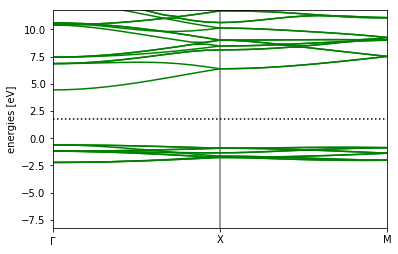

In [6]:
# teacher
from gpaw import GPAW
from ase.dft.bandgap import bandgap
%matplotlib inline

calc = GPAW('NaCl_GXM.gpw', txt=None)
bandgap(calc)
bs = calc.band_structure()
bs.plot(filename='bandstructure.png', show=True, emax=10.0)

## Exercise 6
Calculate the Density of States and the Projected Density of States (on Na and Cl) of NaCl

See https://wiki.fysik.dtu.dk/ase/ase/dft/dos.html and https://wiki.fysik.dtu.dk/gpaw/documentation/pdos/pdos.html#atomic-orbital-pdos for doing DOS and PDOS.

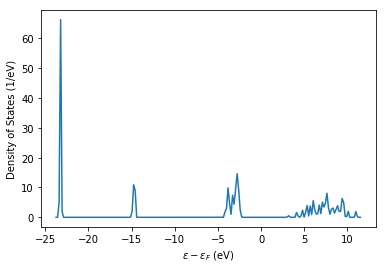

In [7]:
# teacher
import matplotlib.pyplot as plt
from gpaw import GPAW
%matplotlib inline

calc = GPAW('NaCl.gpw', txt=None)
ef = calc.get_fermi_level()
energy, dos = calc.get_dos(spin=0, width=0.1)
plt.plot(energy - ef, dos)
plt.xlabel(r'$\epsilon - \epsilon_F \ \rm{(eV)}$')
plt.ylabel('Density of States (1/eV)')
plt.savefig('DOS.png')
plt.show()

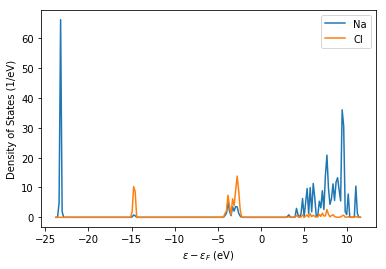

In [8]:
# teacher
import matplotlib.pyplot as plt
from gpaw import GPAW

calc = GPAW('NaCl.gpw', txt=None)

ef = calc.get_fermi_level()
atoms = calc.get_atoms()

pdos_Na = 0
pdos_Cl = 0
for i in range(len(atoms)):
    for c in 'spd':
        energies, pdos = calc.get_orbital_ldos(a=i, angular=c, spin=0, width=0.1)
        if atoms[i].symbol == 'Na':
            pdos_Na += pdos
        elif atoms[i].symbol == 'Cl':
            pdos_Cl += pdos

plt.plot(energies - ef, pdos_Na, label='Na')
plt.plot(energies - ef, pdos_Cl, label='Cl')
plt.xlabel(r'$\epsilon - \epsilon_F \ \rm{(eV)}$')
plt.ylabel('Density of States (1/eV)')
plt.legend()
plt.savefig('PDOS.png')
plt.show()

## Exercise 7
Calculate the work function of the clean slab of Pt111 and of the most stable configuration of H on Pt111.

See https://wiki.fysik.dtu.dk/gpaw/exercises/surface/surface.html#work-function

Work function: 6.40 eV
Difference between ontop and clean surface: 1.213 meV


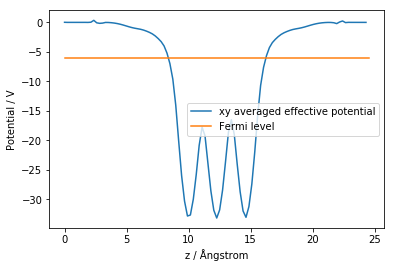

In [9]:
#teacher
import numpy as np
import matplotlib.pyplot as plt
from gpaw import GPAW
%matplotlib inline

def get_workfunction(gpw):
    calc = GPAW(gpw, txt=None)
    slab = calc.get_atoms()

    # Get the height of the unit cell:
    L = np.linalg.norm(slab.get_cell(), axis=1)[2]

    # Get the effective potential on a 3D grid:
    v = calc.get_effective_potential()

    nx, ny, nz = v.shape
    z = np.linspace(0, L, nz, endpoint=False)

    efermi = calc.get_fermi_level()

    # Calculate xy averaged potential:
    vz = v.mean(axis=0).mean(axis=0)
    return L, efermi, z, vz

# Get the difference between the WF of clean and ontop

L, efermi, z, vz = get_workfunction('Pt111_clean.gpw')
L_ot, ef_ot, z_ot, vz_ot = get_workfunction('Pt111_H-ontop.gpw')

wf_clean = vz.max() - efermi
wf_ot = vz_ot.max() - efermi

print('Work function: {:.2f} eV'.format(wf_clean))
print('Difference between ontop and clean surface: {:.3f} meV'.format(1000*(wf_ot-wf_clean)))

# Plot the clean work function
plt.plot(z, vz, label='xy averaged effective potential')
plt.plot([0, L], [efermi, efermi], label='Fermi level')
plt.ylabel('Potential / V')
plt.xlabel('z / Ångstrom')
plt.legend(loc='best')
plt.savefig('workfunction.png', format='png')
plt.show()